# [Rework] Bollinger Bands Strategy with Threshold Crossover

## Concept

From previous experiments, I cam mark peaks and dips(Sell and Buy) points with
a simple rolling window comparison. For a `X` sized window, if the current point
is largest in the `2X` window, it is a peak, and if it is the smallest, it is a dip.

though this does not give the perfectly mapped out time to buy and sell, it does
give a fair descision point.

Now considering that such points can any where across time, when it comes to
intraday scaling, the data presents a fairly mathematical opportunity.

## Strategy

Using Bollinger Bands of window size `W`, and using them to scale the current
close price in time, we can position the current price in a scaled down range
and fairly a stationary time series range. Since Bollinger Bands is a rolling
standard deviation of magnitude `S`, therefore, the points in the close series
becomes relative to the window.

After marking such points, the hypothesis is that the points marked as Peaks and
Dips will have some level of distinction in the scaled down series.


In [2]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import talib
from tqdm import tqdm


def mark_events(data, ref_frame=5):
    data = data.copy()
    data['sell'] = (
        data['close'] == data['close'].shift(-ref_frame).rolling(2 * ref_frame).max()).astype(int).replace(0, None)
    data['buy'] = (
        data['close'] == data['close'].shift(-ref_frame).rolling(2 * ref_frame).min()).astype(int).replace(0, None)
    data['hold'] = data.apply(lambda row: int(
        not (row['sell'] or row['buy'])), axis=1)
    return data


nifty_df = pd.concat(
    list(
        map(
            lambda f: pd.read_csv(
                f,
                parse_dates=True
            ),
            sorted(
                glob('/workspace/nifty/NIFTY/202312*.csv')
            )
        )
    )
)

nifty_df.datetime = pd.to_datetime(nifty_df.datetime)
nifty_df['date'] = nifty_df.datetime.dt.date
nifty_df.set_index('datetime', inplace=True)
nifty_df.drop(columns=['volume', 'exchange_code', 'stock_code'], inplace=True)
dfs = []
for date, group in tqdm(nifty_df.groupby('date')):
    start_index = group.index[0].replace(hour=9, minute=30)
    end_index = group.index[-1].replace(hour=15, minute=15)
    dfs.append(group[start_index:end_index].copy())

nifty_df = pd.concat(dfs)
dates = nifty_df.date.unique()
hist_df = pd.read_csv(
    './hist_df_20231228.csv',
    parse_dates=True
).drop_duplicates().reset_index(drop=True)

hist_df.datetime = pd.to_datetime(hist_df.datetime)
hist_df['date'] = hist_df.datetime.dt.date

nifty_df.head()

100%|██████████| 18/18 [00:00<00:00, 3549.65it/s]

,close,high,low,open,date
datetime,,,,,
2023-12-01 09:30:00,20228.00,20231.75,20225.45,20228.25,2023-12-01
2023-12-01 09:31:00,20230.80,20232.05,20227.60,20228.65,2023-12-01
2023-12-01 09:32:00,20231.30,20232.75,20228.95,20230.95,2023-12-01
2023-12-01 09:33:00,20235.95,20237.60,20230.30,20231.80,2023-12-01
2023-12-01 09:34:00,20226.60,20236.25,20225.70,20235.05,2023-12-01


### Sample Visualization

Scaling Down the Close prices with respect to the bollinger bands needs to treat
the BB upper value as max and BB lower value as min. Using this, the close
prices can be scaled down. Though the behavior in the close price movement shows
some level of lag. This lag can be mitigated by using a smaller window for time
period, but that may lead to noisy data.


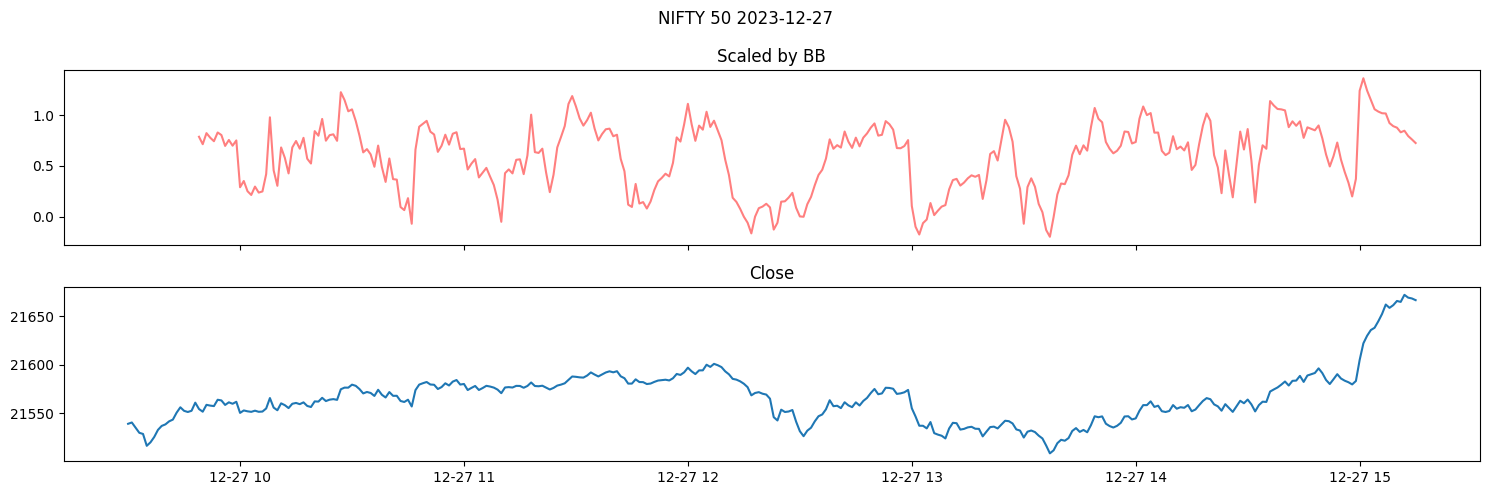

In [3]:

def scale_by_bb(
        series: pd.Series,
        deviation: int = 2,
        timeperiod: int = 20
):
    upper, _, lower = talib.BBANDS(
        series,
        timeperiod=timeperiod,
        nbdevup=deviation,
        nbdevdn=deviation
    )
    return (series - lower) / (upper - lower)


def sample(df: pd.DataFrame, date_index: int = 0):
    _dates = df.date.unique()
    return df[df.date == _dates[date_index]].copy()


fig, (tax, ax) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

ndf = sample(nifty_df, -1)

ax.plot(ndf.close, label='close')
ax.set_title('Close')
tax.plot(scale_by_bb(ndf.close), label='scaled', color='red', alpha=0.5)
tax.set_title('Scaled by BB')
fig.suptitle(f'NIFTY 50 {dates[-1]}')
plt.tight_layout()
plt.show()

Now when i mark the points of interest in the close line and the scaled close
line, what I see is that the points of interest are fairly distinct in the
scaled as well.

Currently by arbitrary buy and sell thresholds, I can see that the points can be
discriminated and a possible regression line can be plotted to formulate the
MDP process.


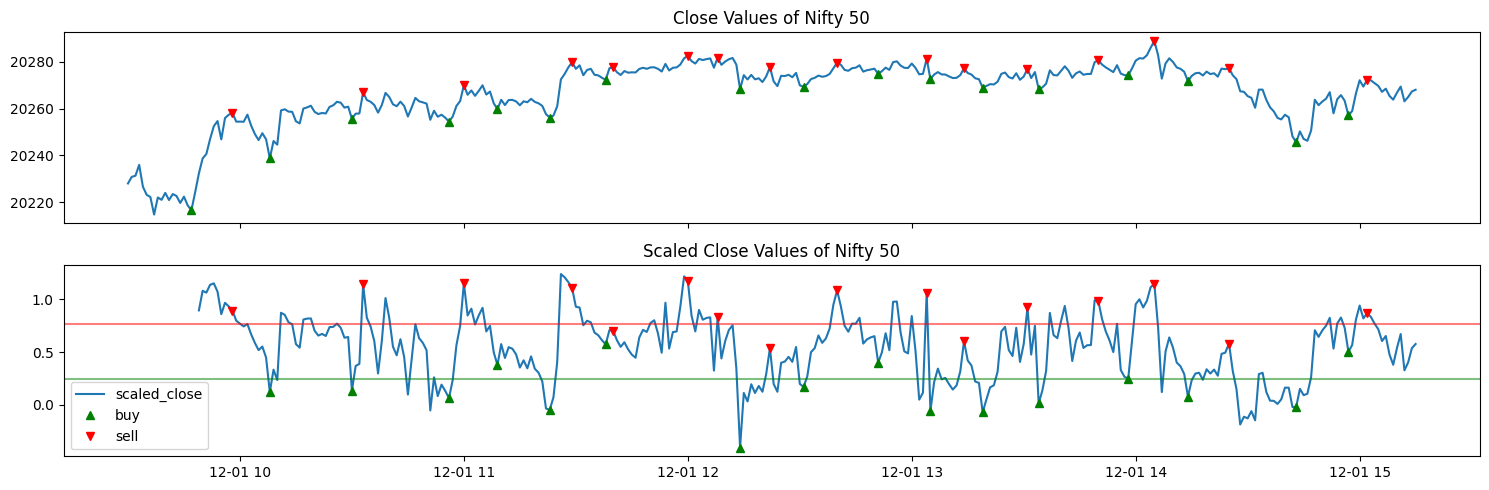

,close,high,low,open,date,sell,buy,hold,scaled_close
datetime,,,,,,,,,
2023-12-01 09:30:00,20228.00,20231.75,20225.45,20228.25,2023-12-01,None,None,1,NaN
2023-12-01 09:31:00,20230.80,20232.05,20227.60,20228.65,2023-12-01,None,None,1,NaN
2023-12-01 09:32:00,20231.30,20232.75,20228.95,20230.95,2023-12-01,None,None,1,NaN
2023-12-01 09:33:00,20235.95,20237.60,20230.30,20231.80,2023-12-01,None,None,1,NaN
2023-12-01 09:34:00,20226.60,20236.25,20225.70,20235.05,2023-12-01,None,None,1,NaN
...,...,...,...,...,...,...,...,...,...
2023-12-01 15:11:00,20269.45,20270.55,20265.55,20267.85,2023-12-01,None,None,1,0.669716
2023-12-01 15:12:00,20263.15,20270.95,20261.45,20270.95,2023-12-01,None,None,1,0.327052
2023-12-01 15:13:00,20265.00,20266.45,20263.00,20263.65,2023-12-01,None,None,1,0.401921


In [6]:


def visualize(
        ndf,
        nbdevup=2,
        timeperiod=20,
        sell_threshold=0.8,
        buy_threshold=0.2,
):

    ndf = ndf.copy()
    _, (nax, tax) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

    ndf['scaled_close'] = scale_by_bb(ndf.close, nbdevup, timeperiod)

    nax.plot(ndf.close, label='close')
    nax.plot(ndf.buy * ndf.close, 'g^', label='buy')
    nax.plot(ndf.sell * ndf.close, 'rv', label='sell')
    nax.set_title('Close Values of Nifty 50')

    tax.plot(ndf['scaled_close'], label='scaled_close')
    tax.plot(ndf.buy * ndf['scaled_close'], 'g^', label='buy')
    tax.plot(ndf.sell * ndf['scaled_close'], 'rv', label='sell')
    tax.axhline(sell_threshold, color='red', alpha=0.5)
    tax.axhline(buy_threshold, color='green', alpha=0.5)
    tax.set_title('Scaled Close Values of Nifty 50')

    plt.legend()
    plt.tight_layout()
    plt.show()
    return ndf


buy_threshold, sell_threshold = 0.248251, 0.760121

ndf = mark_events(
    nifty_df[nifty_df.date == dates[0]],
    ref_frame=8
)

ndf = visualize(
    ndf,
    nbdevup=2,
    timeperiod=20,
    sell_threshold=sell_threshold,
    buy_threshold=buy_threshold
)

ndf

For such a dataset, if i correlate the scaled close values with the sell and buy
points, I can plot a box plot to see the distribution of the 2 action classes.


In [8]:
import numpy as np

BUY_QUANTILE = .85
SELL_QUANTILE = .15
DEVIATION = 2
TIMEPERIOD = 20
REF_FRAME = 12

dfs = []

for date, group in tqdm(nifty_df.groupby('date')):
    group['scaled_close'] = scale_by_bb(group.close, DEVIATION, TIMEPERIOD)
    dfs.append(group)

nifty_df = pd.concat(dfs)

100%|██████████| 18/18 [00:00<00:00, 1956.70it/s]


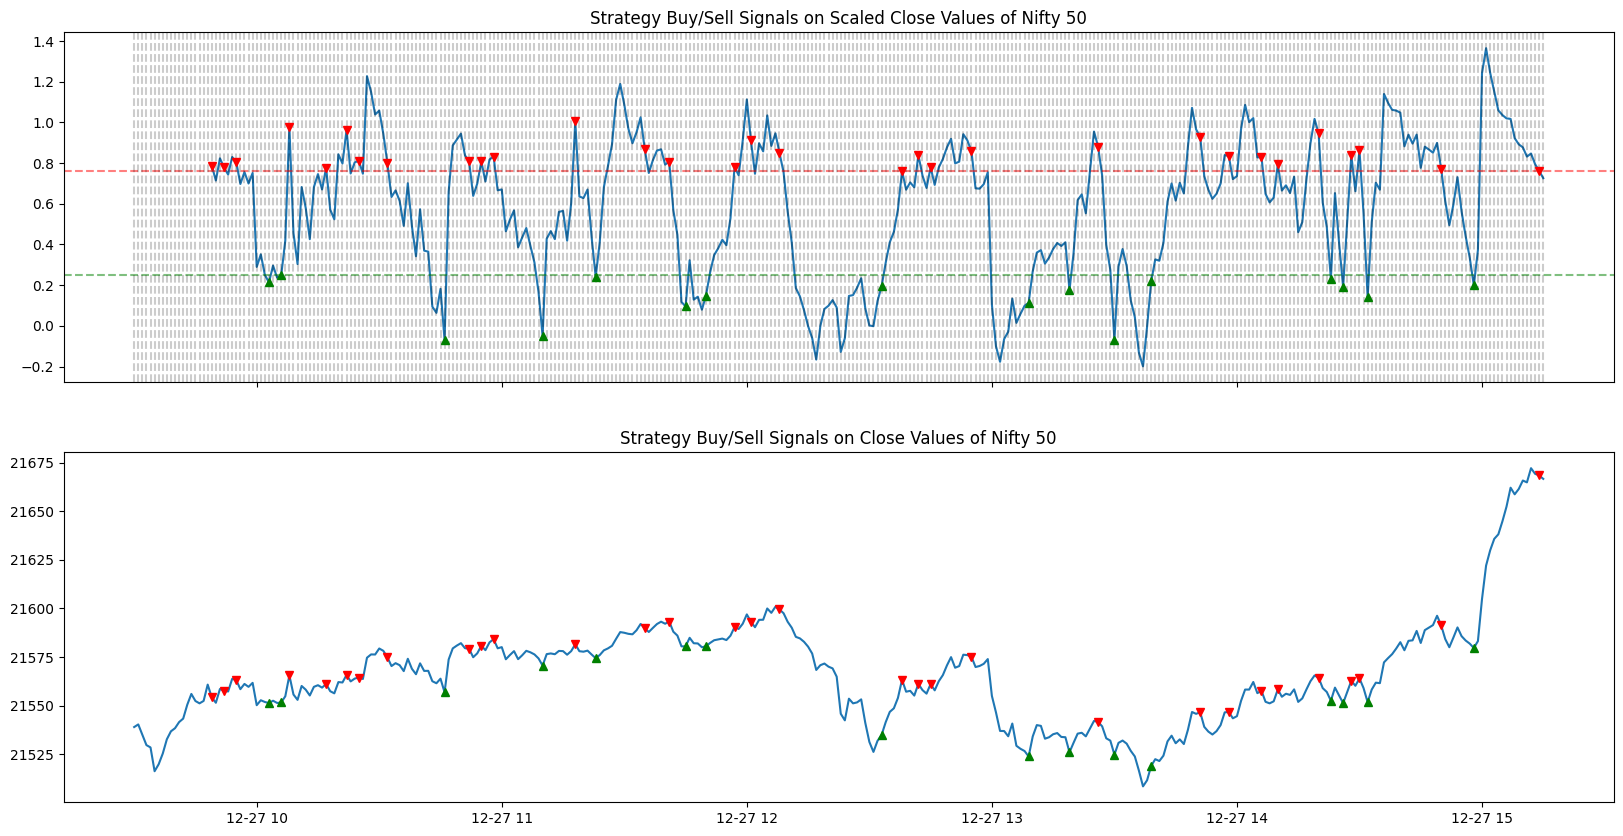

In [11]:
ndf = sample(nifty_df, -1)

ndf['strategy_buy'] = (ndf.scaled_close <= buy_threshold) & (
    ndf.scaled_close.shift(-1) > buy_threshold)
ndf['strategy_sell'] = (ndf.scaled_close >= sell_threshold) & (
    ndf.scaled_close.shift(-1) < sell_threshold)

ndf['strategy_buy'] = ndf['strategy_buy'].astype(int).replace(0, None)
ndf['strategy_sell'] = ndf['strategy_sell'].astype(int).replace(0, None)


fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

hax.plot(ndf.close, label='close')
hax.plot(ndf.close * ndf.strategy_buy, label='scaled_close',
         color='green', marker='^')
hax.plot(ndf.close * ndf.strategy_sell,
         label='scaled_close', color='red', marker='v')
hax.set_title('Strategy Buy/Sell Signals on Close Values of Nifty 50')

ax.plot(ndf.scaled_close, label='scaled_close')
ax.axhline(buy_threshold, color='green', linestyle='--', alpha=0.5)
ax.axhline(sell_threshold, color='red', linestyle='--', alpha=0.5)

for i in ndf.index.values:
    ax.axvline(i, color='black', linestyle='--', alpha=0.2)

ax.plot(ndf.scaled_close * ndf.strategy_buy,
        label='strategy_buy', color='green', marker='^')
ax.plot(ndf.scaled_close * ndf.strategy_sell,
        label='strategy_sell', color='red', marker='v')
ax.set_title('Strategy Buy/Sell Signals on Scaled Close Values of Nifty 50')
plt.show()

Some Outliers were anticipated therefore the threshold on the buy and sell can
be placed at buy: .15 Quantile and sell: .85 Quantile. This leaves some events
which are missed, but most of the events are captured.


In [12]:
from backtesting import Strategy
from typing import Tuple, Callable
import numpy as np

Signal = Tuple[bool, bool, bool]


class BBStrategy(Strategy):
    signal = None
    SL = 5
    TP = 10

    def _is_trading_window(self):
        if (
            self.data.index[-1].hour == 15 and
            self.data.index[-1].minute > 15
        ) or (
            self.data.index[-1].hour == 9 and
            self.data.index[-1].minute < 30
        ):
            return False
        return True

    def __init__(self, broker, data, params):
        super().__init__(broker, data, params)
        self.signal = params['signal']

    def init(self):
        self._open = self.data.Open
        self._high = self.data.High
        self._low = self.data.Low
        self._close = self.data.Close

    def next(self):
        if not self._is_trading_window():
            self.position.close()
            return

        buy, close, sell = self.signal(
            self.data,
            self.position,
            self.trades,
            self.closed_trades
        )

        if close:
            self.position.close()

        if buy:
            self.buy(
                size=1,
                sl=self.data.Low - self.SL,
            )

        if sell:
            self.sell(
                size=1,
                sl=self.data.High + self.SL
            )

In [59]:
from functools import partial

from backtester import simulate
FUNDS_THRESHOLD = 3000000


def mark_action(data, positions, trades, closed_trades):
    buy, close_pos, sell = False, False, False
    # print(positions.is_short, positions.is_long)
    if data.strategy_buy and (not positions.size or positions.is_short):
        buy = True
        close_pos = True
    elif data.strategy_sell and (not positions.size or positions.is_long):
        sell = True
        close_pos = True
    return buy, close_pos, sell


strategy = partial(
    mark_action,
)
# ndf = mark_events(
#     sample(nifty_df, -1),
#     REF_FRAME
# )

# ndf = sample(nifty_df, -2)
ndf = nifty_df[nifty_df.date.isin(hist_df.date)].copy()

# ndf['strategy_buy'] = (ndf.scaled_close >= buy_threshold) & (
#     ndf.scaled_close.shift(1) < buy_threshold)
# ndf['strategy_sell'] = (ndf.scaled_close <= sell_threshold) & (
#     ndf.scaled_close.shift(1) > sell_threshold)

ndf['strategy_buy'] = (ndf.scaled_close <= buy_threshold) & (
    ndf.scaled_close.shift(1) > buy_threshold)
ndf['strategy_sell'] = (ndf.scaled_close >= sell_threshold) & (
    ndf.scaled_close.shift(1) < sell_threshold)

ndf['strategy_buy'] = ndf['strategy_buy'].astype(int).replace(0, None)
ndf['strategy_sell'] = ndf['strategy_sell'].astype(int).replace(0, None)

stats = simulate(
    ndf.rename(
        {
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
        },
        axis=1
    )[:],
    cash=30000,
    strategy=strategy,
    backtest_class=BBStrategy,
)

print(stats)

Start                     2023-12-11 09:30:00
End                       2023-12-27 15:15:00
Duration                     16 days 05:45:00
Exposure Time [%]                   51.565511
Equity Final [$]                     30321.65
Equity Peak [$]                       30328.4
Return [%]                           1.072167
Buy & Hold Return [%]                3.329995
Return (Ann.) [%]                   18.128159
Volatility (Ann.) [%]                 1.62733
Sharpe Ratio                        11.139818
Sortino Ratio                       54.705711
Calmar Ratio                        56.600046
Max. Drawdown [%]                   -0.320285
Avg. Drawdown [%]                   -0.067661
Max. Drawdown Duration        5 days 22:56:00
Avg. Drawdown Duration        0 days 10:48:00
# Trades                                  326
Win Rate [%]                         34.04908
Best Trade [%]                       0.462554
Worst Trade [%]                     -0.064516
Avg. Trade [%]                    

In [70]:

odf = hist_df[hist_df.date.isin(ndf.date.unique())].copy()
trades_df = stats._trades

expiries = odf['expiry_date'].unique()
expiry = expiries[0]
lot_size = 50
lots = 10

initial_funds = funds = 500_000
# print('Expiry: ', expiry, 'EntryPrice',
#       rec['EntryPrice'], 'EntryTime', rec['EntryTime'])

records = []

for rec in tqdm(trades_df.to_dict('records')[:]):
    try:

        _odf = odf[
            (
                odf['datetime'].isin([rec['EntryTime'], rec['ExitTime']])
            ) & (
                odf['expiry_date'] == expiry
            )
        ]

        distance = (rec['EntryPrice'] - _odf['strike_price']).abs()
        price_dict = _odf[
            (
                _odf['right'] == ('Call' if rec['Size'] == 1 else 'Put')
            ) & (
                distance == distance.min()
            )
        ].set_index('datetime').to_dict('index')

        rec['OptionStrikePrice'] = price_dict[rec['EntryTime']]['strike_price']
        rec['OptionExpiry'] = price_dict[rec['EntryTime']]['expiry_date']
        rec['OptionEntryPrice'] = price_dict[rec['EntryTime']]['close']
        rec['OptionExitPrice'] = price_dict[rec['ExitTime']]['close']
        rec['OptionBuying'] = rec['OptionEntryPrice'] * lot_size * lots
        rec['OptionSelling'] = rec['OptionExitPrice'] * lot_size * lots
        rec['OptionPnL'] = rec['OptionSelling'] - rec['OptionBuying']

        if rec['OptionBuying'] > funds:
            continue
        funds -= rec['OptionBuying']
        funds += rec['OptionSelling']
        funds -= 45 * 2  # Approx Brokerage
        # continue
        rec['Funds'] = funds
        records.append(rec)
    except Exception as e:
        continue

trades_df = pd.DataFrame(records)
# print(np.round(trades_df.OptionPnL.sum(), 1) - trades_df.shape[0] * 45)
print(trades_df.OptionPnL.sum())
print(trades_df.OptionPnL.quantile([.05, .25, .5, .75, .95]))
print(trades_df.Funds.iloc[-1]/initial_funds)

trades_df

100%|██████████| 326/326 [00:18<00:00, 18.10it/s]

-41625.00000000027
0.05   -4725.00
0.25   -2306.25
0.50    -650.00
0.75    1593.75
0.95    6085.00
Name: OptionPnL, dtype: float64
0.87319


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,OptionStrikePrice,OptionExpiry,OptionEntryPrice,OptionExitPrice,OptionBuying,OptionSelling,OptionPnL,Funds
0,1,1077,1084,21167.75,21161.75,-6.00,-0.000283,2023-12-14 10:09:00,2023-12-14 10:16:00,0 days 00:07:00,21150.0,04-JAN-2024,302.45,296.70,151225.0,148350.0,-2875.0,497035.0
1,1,1101,1115,21138.80,21159.00,20.20,0.000956,2023-12-14 10:33:00,2023-12-14 10:47:00,0 days 00:14:00,21150.0,04-JAN-2024,286.10,289.90,143050.0,144950.0,1900.0,498845.0
2,-1,1115,1116,21159.00,21165.10,-6.10,-0.000288,2023-12-14 10:47:00,2023-12-14 10:48:00,0 days 00:01:00,21150.0,04-JAN-2024,151.15,151.15,75575.0,75575.0,0.0,498755.0
3,-1,1127,1144,21161.00,21168.20,-7.20,-0.000340,2023-12-14 10:59:00,2023-12-14 11:16:00,0 days 00:17:00,21150.0,04-JAN-2024,153.65,155.20,76825.0,77600.0,775.0,499440.0
4,-1,1153,1156,21164.95,21159.70,5.25,0.000248,2023-12-14 11:25:00,2023-12-14 11:28:00,0 days 00:03:00,21150.0,04-JAN-2024,154.85,154.75,77425.0,77375.0,-50.0,499300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,-1,4104,4108,21562.75,21551.75,11.00,0.000510,2023-12-27 14:28:00,2023-12-27 14:32:00,0 days 00:04:00,21550.0,04-JAN-2024,126.35,131.00,63175.0,65500.0,2325.0,425780.0
238,1,4108,4112,21551.75,21572.25,20.50,0.000951,2023-12-27 14:32:00,2023-12-27 14:36:00,0 days 00:04:00,21550.0,04-JAN-2024,235.05,250.00,117525.0,125000.0,7475.0,433165.0
239,-1,4112,4114,21572.25,21578.65,-6.40,-0.000297,2023-12-27 14:36:00,2023-12-27 14:38:00,0 days 00:02:00,21550.0,04-JAN-2024,118.15,118.20,59075.0,59100.0,25.0,433100.0
240,1,4134,4136,21579.65,21604.85,25.20,0.001168,2023-12-27 14:58:00,2023-12-27 15:00:00,0 days 00:02:00,21600.0,04-JAN-2024,226.10,241.20,113050.0,120600.0,7550.0,440560.0


In [69]:
_trades_df = trades_df.copy().set_index('EntryTime')

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(_trades_df.Funds)
ax.axhline(initial_funds, color='red', linestyle='--', alpha=0.5)
ax.axhline(_trades_df.Funds.iloc[-1],
           color='green', linestyle='--', alpha=0.5)
ax.set_title('Funds')
plt.show()

KeyError: "None of ['EntryTime'] are in the columns"

In [68]:
trades_df['date'] = trades_df.EntryTime.dt.date
trades_df.groupby('date').OptionPnL.sum().plot.bar(figsize=(15, 5))

# OptionBuying.quantile([.05, .25, .5, .75, .95]).reset_index().pivot(
#     index='date', columns='level_1', values='OptionBuying')

AttributeError: 'DataFrame' object has no attribute 'EntryTime'

In [66]:
trades_df['date'] = trades_df.EntryTime.dt.date
trades_df.groupby('date').OptionBuying.quantile([.05, .25, .5, .75, .95]).reset_index().pivot(
    index='date', columns='level_1', values='OptionBuying')

AttributeError: 'DataFrame' object has no attribute 'EntryTime'

In [65]:
metrics_df = pd.read_csv('./metrics.csv')
print(metrics_df[['Win Rate [%]', 'Return [%]', '# Trades', 'Avg. Drawdown [%]']
                 ].quantile([.05, .25, .5, .75, .95]))
metrics_df

      Win Rate [%]  Return [%]  # Trades  Avg. Drawdown [%]
0.05     39.255031   12.950794   17448.0          -0.040639
0.25     58.570393   20.337114   19216.0          -0.032631
0.50     66.730653   36.377138   20530.0          -0.027531
0.75     68.875264   49.445796   24036.0          -0.023648
0.95     71.493163   84.305210   30021.4          -0.015183


,stock_code,initial_cash,buy_threshold,sell_threshold,Return [%],Equity Final [$],Avg. Drawdown [%],# Trades,Win Rate [%],Avg. Trade Duration,Expectancy [%]
0,ADAENT,20950.00,0.252955,0.737469,14.590215,3056.65,-0.034906,21303,56.189269,0 days 00:13:00,0.007884
1,ADAPOR,5510.00,0.246095,0.718789,18.511797,1020.00,-0.033592,18233,66.730653,0 days 00:18:00,0.011498
2,APOHOS,29677.00,0.264114,0.721870,49.169053,14591.90,-0.026789,25228,51.149516,0 days 00:09:00,0.014198
3,ASIPAI,17950.00,0.273871,0.711830,36.811699,6607.70,-0.028575,22933,60.528496,0 days 00:12:00,0.010378
4,AXIBAN,5758.75,0.262270,0.741518,14.258303,821.10,-0.036103,17892,66.957299,0 days 00:18:00,0.002743
5,BAAUTO,33697.00,0.262205,0.675073,49.445796,16661.75,-0.017512,25998,56.923610,0 days 00:10:00,0.016989
6,BAFINS,96625.00,0.252532,0.730974,41.088900,39702.15,-0.017312,27471,38.695351,0 days 00:08:00,0.014833
7,BAJFI,40957.75,0.245113,0.740624,38.940616,15949.20,-0.029400,27054,39.628151,0 days 00:08:00,0.008976
8,BHAAIR,5229.75,0.281095,0.715907,18.205459,952.10,-0.033712,18574,68.321309,0 days 00:18:00,0.006462
9,BHAPET,2550.00,0.283687,0.705077,33.372549,851.00,-0.037522,18691,68.530309,0 days 00:18:00,0.011424


In [64]:
metrics_df = pd.read_csv('./metrics.csv')
print(metrics_df[['Win Rate [%]', 'Return [%]', '# Trades', 'Avg. Drawdown [%]']
                 ].quantile([.05, .25, .5, .75, .95]))
metrics_df

      Win Rate [%]  Return [%]  # Trades  Avg. Drawdown [%]
0.05     39.255031   12.950794   17448.0          -0.040639
0.25     58.570393   20.337114   19216.0          -0.032631
0.50     66.730653   36.377138   20530.0          -0.027531
0.75     68.875264   49.445796   24036.0          -0.023648
0.95     71.493163   84.305210   30021.4          -0.015183


,stock_code,initial_cash,buy_threshold,sell_threshold,Return [%],Equity Final [$],Avg. Drawdown [%],# Trades,Win Rate [%],Avg. Trade Duration,Expectancy [%]
0,ADAENT,20950.00,0.252955,0.737469,14.590215,3056.65,-0.034906,21303,56.189269,0 days 00:13:00,0.007884
1,ADAPOR,5510.00,0.246095,0.718789,18.511797,1020.00,-0.033592,18233,66.730653,0 days 00:18:00,0.011498
2,APOHOS,29677.00,0.264114,0.721870,49.169053,14591.90,-0.026789,25228,51.149516,0 days 00:09:00,0.014198
3,ASIPAI,17950.00,0.273871,0.711830,36.811699,6607.70,-0.028575,22933,60.528496,0 days 00:12:00,0.010378
4,AXIBAN,5758.75,0.262270,0.741518,14.258303,821.10,-0.036103,17892,66.957299,0 days 00:18:00,0.002743
5,BAAUTO,33697.00,0.262205,0.675073,49.445796,16661.75,-0.017512,25998,56.923610,0 days 00:10:00,0.016989
6,BAFINS,96625.00,0.252532,0.730974,41.088900,39702.15,-0.017312,27471,38.695351,0 days 00:08:00,0.014833
7,BAJFI,40957.75,0.245113,0.740624,38.940616,15949.20,-0.029400,27054,39.628151,0 days 00:08:00,0.008976
8,BHAAIR,5229.75,0.281095,0.715907,18.205459,952.10,-0.033712,18574,68.321309,0 days 00:18:00,0.006462
9,BHAPET,2550.00,0.283687,0.705077,33.372549,851.00,-0.037522,18691,68.530309,0 days 00:18:00,0.011424


In [67]:
trades_df = pd.read_csv('./all_trades.csv')
trades_df

,trade_id,strike_price,spot_price,expiry_date,right,ltp,open,high,low,previous_close
0,0,21700.0,21717.05,04-Jan-2024,Put,123.25,100.00,154.90,78.45,100.45
1,0,21700.0,21739.55,04-Jan-2024,Put,104.40,100.00,154.90,78.45,100.45
2,1,21750.0,21739.55,04-Jan-2024,Call,172.20,249.75,249.75,122.75,214.90
3,1,21750.0,21748.15,04-Jan-2024,Call,183.15,249.75,249.75,122.75,214.90
4,2,21750.0,21749.25,04-Jan-2024,Put,115.65,135.00,181.40,90.00,118.50
5,2,21750.0,21730.35,04-Jan-2024,Put,128.35,135.00,181.40,90.00,118.50
6,3,21750.0,21730.35,04-Jan-2024,Call,164.95,249.75,249.75,122.75,214.90
7,3,21750.0,21722.50,04-Jan-2024,Call,153.50,249.75,249.75,122.75,214.90
8,4,21700.0,21720.70,04-Jan-2024,Put,113.50,100.00,154.90,78.45,100.45
9,4,21700.0,21729.70,04-Jan-2024,Put,106.20,100.00,154.90,78.45,100.45
